# Real-Valued QM Experiment via IBM Quantum (Sampler version)

<b>Note: </b> [Qiskit](https://qiskit.org/) 1.x must be installed for this to run on a local device. To run circuits on actual quantum hardware, Qiskit Runtime must also be installed. 

In [185]:
from qiskit import *
import numpy as np
from matplotlib import pyplot as plt

Alice and Charlie each select one from a set of operators to measure. Each operator can be represented by a computational basis measurement after rotating the qubit by spherical angles $(-\phi,-\theta)$. Twelve combinations are used.

With the measurement configuration selected randomly, the basic scheme is to run each of the 12 cases for a large number of shots within a single job. 

In [186]:
thet2a = np.pi/2
phi2a = 0.0

thet3a = np.pi/2
phi3a = np.pi/2

thet1a = 0.0
phi1a = 0.0

thet1b = np.pi/4
phi1b = 0.0

thet2b = -np.pi/4
phi2b = 0.0

thet3b = np.pi/4
phi3b = np.pi/2

thet4b = np.pi/4
phi4b = -np.pi/2

thet5b = np.pi/2
phi5b = np.pi/4

thet6b = np.pi/2
phi6b = -np.pi/4

angles = np.array([[phi1a,thet1a,phi1b,thet1b],[phi1a,thet1a,phi2b,thet2b],
                   [phi2a,thet2a,phi1b,thet1b],[phi2a,thet2a,phi2b,thet2b],
                   [phi1a,thet1a,phi3b,thet3b],[phi1a,thet1a,phi4b,thet4b],
                   [phi3a,thet3a,phi3b,thet3b],[phi3a,thet3a,phi4b,thet4b],
                   [phi2a,thet2a,phi5b,thet5b],[phi2a,thet2a,phi6b,thet6b],
                   [phi3a,thet3a,phi5b,thet5b],[phi3a,thet3a,phi6b,thet6b]])

Each operator corresponds to a spin measurement in a particular direction. Since measurements employ the computational ($\hat{S}^{z}$) basis, one first rotates the system before performing a measurement.

Specifically, suppose one wishes to measure spin about the direction $\hat{\bf n} = \sin\theta\cos\phi\hat{\bf x} + \sin\theta\sin\phi\hat{\bf y} + \cos\theta\hat{\bf z}$. One creates $\hat{\bf n}$ by rotating $\hat{\bf z}$ an angle $\theta$ about the $y$-axis followed by an angle $\phi$ about the $z$ axis. Consequently, one should rotate the system by $-\phi$ about the $z$-direction and then $-\theta$ about the $y$-direction. This system rotation is accomplished by two successive rotation gates, $\hat{R}_{z}(-\phi)\hat{R}_{y}(-\theta)$.

One could create a circuit for each of the 12 measurement configurations (choices of $\theta$, $\phi$ for Alice and Charlie) or create a single circuit with four parameters. A list of parameters supplied with the circuit will ensure the circuit is run for all cases. In the following, we use a single circuit with a parameter object for each rotation angle. 

The circuit creates two Bell states of the form

$$|q_{0}q_{1}\rangle = |q_{2}q_{3}\rangle = \frac{1}{\sqrt{2}}\left(|00\rangle + |11\rangle\right)$$

Alice measures $|q_{0}\rangle$, Charlie measures $|q_{3}\rangle$, and Bob performs a Bell state measurement on $|q_{1}q_{2}\rangle$. To accomplish the Bell state measurement, a CNOT and Hadamard operation are used (the reverse operation of <i>creating</i> a particular Bell state) to perform the following transformations

$$(|00\rangle + |11\rangle)/\sqrt{2} \rightarrow |00\rangle$$
$$(|00\rangle - |11\rangle)/\sqrt{2} \rightarrow |10\rangle$$
$$(|01\rangle + |10\rangle)/\sqrt{2} \rightarrow |01\rangle$$
$$(|01\rangle - |10\rangle)/\sqrt{2} \rightarrow |11\rangle$$

Thus, by performing a computational basis measurement on his two qubits, Bob can determine which Bell state the configuration was in (before the CNOT/Hadamard operation).

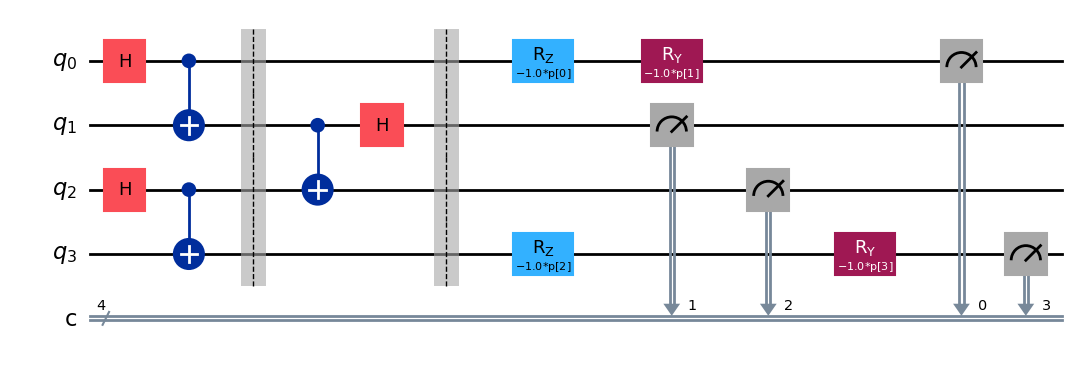

In [187]:
phi1_vals = angles[:,0]
theta1_vals = angles[:,1]
phi2_vals = angles[:,2]
theta2_vals = angles[:,3]

from qiskit.circuit import ParameterVector

p = ParameterVector('p', 4)  

qb = [0,1,2,3]

qr = QuantumRegister(4,'q')
cr = ClassicalRegister(4,'c')
circ = QuantumCircuit(qr,cr)

circ.h(qb[0])
circ.cx(qb[0],qb[1])

circ.h(qb[2])
circ.cx(qb[2],qb[3])

circ.barrier(qr)

circ.cx(qb[1],qb[2])
circ.h(qb[1])

circ.barrier(qr)


circ.rz(-p[0],qb[0])
circ.ry(-p[1],qb[0])

circ.rz(-p[2],qb[3])
circ.ry(-p[3],qb[3])


circ.measure(qb,cr)

circ.draw('mpl')

### Simulation

We can explore the behavior of this circuit using the `StatevectorSampler` simulator, which generates pseudorandom counts which would be expected if the circuit were run on actual hardware. All fluctuations are statistical.

The format for running this circuit entails bundling the circuit and set of parameters into a primitive unified bloc (PUB).

In [188]:
from qiskit.primitives import StatevectorSampler

sampler = StatevectorSampler()

nshots = 8192

pub = (circ, angles)

job = sampler.run([pub], shots=nshots)
result = job.result()[0]

The output of this job is a set of all counts written to the classical register during the course of the four measurements per set of parameters (12 total). For `i` in the range 0 to 11, the counts are displayed as follows.

In [189]:
counts = result.data.c.get_counts
counts(0)

{'1001': 877,
 '0110': 149,
 '1101': 153,
 '1011': 904,
 '0000': 852,
 '0111': 919,
 '0101': 893,
 '0010': 856,
 '0100': 133,
 '0001': 175,
 '1100': 849,
 '1000': 164,
 '1110': 841,
 '0011': 151,
 '1010': 126,
 '1111': 150}

What remains is reconstruct the probability distribution (and then conditional expectation values) from the raw counts. Let us first reconstruct the joint conditional probabilities $P(abc|xz)$ by simply normalizing the counts for each state to obtain $p_{s} = \mbox{counts}(s)/N$.

This step involves nothing more than dividing the counts for each state by the total number of shots and arranging all values (in the same order) in a two-dimensional array.

In [190]:
Pabc=np.zeros((16,12))

for i in range(0,12):
    counts1 = counts(i)
    keylist = list(counts1.keys())
    for j in range(0,len(keylist)):
        state = keylist[j]

        Pabc[int(state[::-1],2),i] = counts1[state] 


Ns = sum(Pabc)
for i in range(0,12):
    Pabc[:,i] = Pabc[:,i]/Ns[i]

Note that `Ns` should be an array containing the (same) number of shots for each entry.

In [191]:
Ns

array([8192., 8192., 8192., 8192., 8192., 8192., 8192., 8192., 8192.,
       8192., 8192., 8192.])

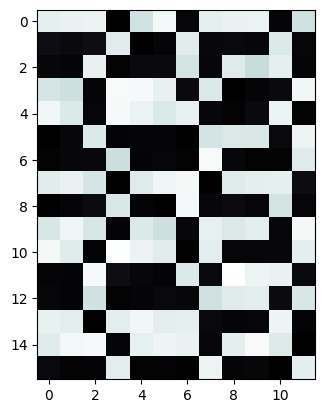

In [192]:
plt.imshow(Pabc,cmap='bone')
plt.show()

Next, we compute the quantities $S_{xz}^{b}$, which are effectively the expectation values $\langle \hat{A}_{x}\otimes |\Phi_{b}\rangle \langle \Phi_{b}|\otimes \hat{C}_{z}\rangle$. That is, $S_{xz}^{b}$ is the expectation value $\langle \hat{A}_{x}\hat{C}_{z}\rangle$ conditioned upon Bob obtaining the state $|\Phi_{b}\rangle$,

$$S_{xz}^{b} = \sum_{a,c=\pm 1}P(abc|xz)ac$$

To accomplish this, we directly peel the corresponding values for $a,c$ from the bitstrings labeling the states. Consider the state $|0011\rangle$. This state indicates $a = +1$ ($q_{0} = 0$) and $c = -1$ ($q_{3} = 1$). In general, $a=2\left(\frac{1}{2}-q_{0}\right)$, $c=2\left(\frac{1}{2}-q_{3}\right)$. 

In [193]:
Sb = np.zeros((4,12))

for i in range(0,4):
    ib = format(i,'b').zfill(2)
    for j in range(0,12):
        for k in range(0,16):
            kb = format(k,'b').zfill(4)

            ac = 4*(float(kb[0])-0.5)*(float(kb[3])-0.5)

            if (kb[1:3]==ib):
                Sb[i,j] = Sb[i,j] + Pabc[k,j]*ac

Lastly, we perform the weighted sum

$$\mathcal{T}_{b} = (-1)^{b_{2}}(S_{11}^{b}+S_{12}^{b}) + (-1)^{b_{1}}(S_{21}^{b}-S_{22}^{b}) + (-1)^{b_{2}}(S_{13}^{b}+S_{14}^{b})-(-1)^{b_{1}+b_{2}}(S_{33}^{b}-S_{34}^{b}) + (-1)^{b_{1}}(S_{25}^{b}+S_{26}^{b})-(-1)^{b_{1}+b_{2}}(S_{35}^{b}-S_{36}^{b})$$

In [194]:
Tb = np.zeros(4)

for i in range(0,4):
    b = format(i,'b').zfill(2)
    b1 = int(b[0])
    b2 = int(b[1])

    Tb[i] = Tb[i] + ((-1.0)**(b2))*(Sb[i,0]+Sb[i,1]) + ((-1.0)**b1)*(Sb[i,2]-Sb[i,3])
    Tb[i] = Tb[i] + ((-1.0)**b2)*(Sb[i,4]+Sb[i,5]) - ((-1.0)**(b1+b2))*(Sb[i,6]-Sb[i,7])
    Tb[i] = Tb[i] + ((-1.0)**b1)*(Sb[i,8]+Sb[i,9]) - ((-1.0)**(b1+b2))*(Sb[i,10]-Sb[i,11])

Lastly, we sum the four $\mathcal{T}_{b}$ to obtain $\Gamma$, with a theoretical value of $6\sqrt{2}\approx 8.485$

In [195]:
print(sum(Tb))

8.4912109375


### Actual Hardware (including error mitigation)
### * Requires Qiskit Runtime and (free) IBM Quantum Account *

The exact same steps can be used to run the basic circuit on quantum hardware. For brevity, we repeat the steps to construct the circuit. This time, we use a list so that we can simply append the additional circuit needed for error mitigation. The list `circs` contains all twelve individual circuits created in the loop over rotation angles.

In [174]:
thet2a = np.pi/2
phi2a = 0.0

thet3a = np.pi/2
phi3a = np.pi/2

thet1a = 0.0
phi1a = 0.0

thet1b = np.pi/4
phi1b = 0.0

thet2b = -np.pi/4
phi2b = 0.0

thet3b = np.pi/4
phi3b = np.pi/2

thet4b = np.pi/4
phi4b = -np.pi/2

thet5b = np.pi/2
phi5b = np.pi/4

thet6b = np.pi/2
phi6b = -np.pi/4

angles = np.array([[phi1a,thet1a,phi1b,thet1b],[phi1a,thet1a,phi2b,thet2b],
                   [phi2a,thet2a,phi1b,thet1b],[phi2a,thet2a,phi2b,thet2b],
                   [phi1a,thet1a,phi3b,thet3b],[phi1a,thet1a,phi4b,thet4b],
                   [phi3a,thet3a,phi3b,thet3b],[phi3a,thet3a,phi4b,thet4b],
                   [phi2a,thet2a,phi5b,thet5b],[phi2a,thet2a,phi6b,thet6b],
                   [phi3a,thet3a,phi5b,thet5b],[phi3a,thet3a,phi6b,thet6b]])

phi1_vals = angles[:,0]
theta1_vals = angles[:,1]
phi2_vals = angles[:,2]
theta2_vals = angles[:,3]

circs = []

for i in range(0,12):
    qb = [0,1,2,3]
    
    qr = QuantumRegister(4,'q')
    cr = ClassicalRegister(4,'c')
    circ = QuantumCircuit(qr,cr)
    
    circ.h(qb[0])
    circ.cx(qb[0],qb[1])
    
    circ.h(qb[2])
    circ.cx(qb[2],qb[3])
    
    circ.barrier(qr)
    
    circ.cx(qb[1],qb[2])
    circ.h(qb[1])
    
    circ.barrier(qr)
    
    
    circ.rz(-phi1_vals[i],qb[0])
    circ.ry(-theta1_vals[i],qb[0])
    
    circ.rz(-phi2_vals[i],qb[3])
    circ.ry(-theta2_vals[i],qb[3])
    
    circ.measure(qb,cr)

    circs.append(circ)

The basic idea behind readout error mitigation is to create each possible state of qubits and perform a measurement of all qubits. Suppose we create $|0101\rangle$. <i>Most</i> actual counts will correspond to the actual state, but there will be some instances of $|0000\rangle$, $|0001\rangle$, ..., $|1111\rangle$. Repeating this process for all possible states, we can construct a matrix $C$, which converts from expected to actual counts obtained on a particular device. Inverting this matrix allows us to approximately correct the actual counts obtained after running <i>any</i> circuit

$$\mbox{corrected counts} = C^{-1}(\mbox{actual counts})$$

Below we loop over all possible four-qubit states and create a circuit to initialize and measure each. For four qubits, we count from 0 to 15 and convert each integer to a bit string (0000, 0001, ...., 1111). For each integer, the placement of 1's indicates where to apply NOT gates. 

These circuits are appended to `circs` to be run in a single job.

In [175]:
def mitigation_circ(N):
    Ncirc = 2**N
    circlist = []
    
    for i in range(0,Ncirc):
        qr = QuantumRegister(4,'q')
        cr = ClassicalRegister(N,'c')
        qb = [0,1,2,3]
        
        circ = QuantumCircuit(qr,cr)
        
        x = format(i, "b")
        
        while (len(x)<N):
            x = '0'+x
            
        for j in range(0,N):
            if (x[j]=='1'):
                circ.x(qb[j])
                
        circ.measure(qb,cr)
        
        circlist.append(circ)
    return circlist

mitcircs = mitigation_circ(4)

for i in range(0,16):
    circs.append(mitcircs[i])

To run on actual hardware, the circuit (or list of circuits) needs to be converted to form using only native gates on a particular device. We first log in and select a device.

In [176]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum", token="<YOUR-API-TOKEN-HERE>")

#least-busy option
#backend = service.least_busy(simulator=False, operational=True)
#backend.name

#select particular device
backend = service.backend("ibm_brisbane")
backend.name

'ibm_brisbane'

The following optimizes the circuit before running.

In [177]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuits = pm.run(circs)

We note that one may specify specific qubits (e.g., 0,1,2,3) at this stage by replacing the above line with

```pm = generate_preset_pass_manager(backend=backend, optimization_level=1,initial_layout=[0,1,2,3])```

Thanks to Reviewer #3 for point this out!

The syntax for running on actual hardware is quite similar to running on a simulator:

In [178]:
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler 

nshots = 1024
sampler = Sampler(backend)
job = sampler.run(isa_circuits,shots=nshots)

job_result = job.result()

If you interrupt the Jupyter notebook kernel, you can retrieve the job later using the following code (also provided by IBM when you pull up your job through your IBM account):

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='<YOUR-API-TOKEN-HERE>')

job = service.job('<JOB-ID-HERE>')
job_result = job.result()

To process, we first split up the experimental results from those used for error mitigation. 

In [179]:
job_results = job_result[0:12]
mit_results = job_result[12:]

We can look at the raw counts first by simply repeating the same post-processing used above for the simulator results. The combined results are packaged slightly differently in this case due to using a list of circuits instead of a PUB.

In [180]:
Pabc=np.zeros((16,12))

for i in range(0,12):
    counts1 = job_results[i].data.c.get_counts()
    keylist = list(counts1.keys())
    for j in range(0,len(keylist)):
        state = keylist[j]

        Pabc[int(state[::-1],2),i] = counts1[state] 


Ns = sum(Pabc)
for i in range(0,12):
    Pabc[:,i] = Pabc[:,i]/Ns[i]

Sb = np.zeros((4,12))

for i in range(0,4):
    ib = format(i,'b').zfill(2)
    for j in range(0,12):
        for k in range(0,16):
            kb = format(k,'b').zfill(4)

            ac = 4*(float(kb[0])-0.5)*(float(kb[3])-0.5)

            if (kb[1:3]==ib):
                Sb[i,j] = Sb[i,j] + Pabc[k,j]*ac

Tb = np.zeros(4)

for i in range(0,4):
    b = format(i,'b').zfill(2)
    b1 = int(b[0])
    b2 = int(b[1])

    Tb[i] = Tb[i] + ((-1.0)**(b2))*(Sb[i,0]+Sb[i,1]) + ((-1.0)**b1)*(Sb[i,2]-Sb[i,3])
    Tb[i] = Tb[i] + ((-1.0)**b2)*(Sb[i,4]+Sb[i,5]) - ((-1.0)**(b1+b2))*(Sb[i,6]-Sb[i,7])
    Tb[i] = Tb[i] + ((-1.0)**b1)*(Sb[i,8]+Sb[i,9]) - ((-1.0)**(b1+b2))*(Sb[i,10]-Sb[i,11])

print(sum(Tb))

6.599609375


Next, we use the calibration circuit results to build the matrix $C$. The following cell systematically normalizes the counts obtained from the calibration circuit to convert them to a row of the matrix $C$ such that

$$\mbox{actual counts} = C\mbox{(expected counts)}$$

In [181]:
N = 4
dictlist = []

Ntot = 2**N

qcountsbare = {}

for i in range(0,Ntot):
    x = format(i, "b")

    while (len(x)<N):
        x = '0'+x
    x = x[::-1]

    qcountsbare[x] = 0
    dictlist.append(x)

C = np.matrix(np.zeros((2**N,2**N)))

for i in range(0,2**N):
    row = {**qcountsbare, **mit_results[i].data.c.get_counts()}
    for j in range(0,2**N):
        C[i,j] = row[dictlist[j]]/nshots

The next step is to process the raw counts. The simplest method is to simply invert $C$. For a number of technical reasons, one generally uses the <i>pseudo</i>inverse function, `pinv()`. Loosely, this approach is useful because we are working with noisy data. It's <i>possible</i> that the fluctuations could make a precise inversion problematic to compute numerically. 

One potentially alarming side effect of this method is that it's possible to obtain <i>negative</i> corrected counts. In practice, these are typically small enough to have little effect on the final result. The formal way of allieviating concern about negative counts is to interpret the resulting (corrected) distribution as a [pseudo-probability distribution](https://quantumcomputing.stackexchange.com/questions/18343/manual-measurement-error-mitigation-returning-a-negative-number-of-counts).

To accomplish the error mitigation, we define a function to input the raw counts and output the mitigated counts. Here `raw_counts` is a list of the Python dictionaries containing raw counts for each circuit, `C` is the calibration matrix computed above, `N=4` is the number of qubits, and `Nt=12` is the total number of circuits. 

In [182]:
def errormit(raw_counts,C,N,Nt):
    #invert matrix (pseudoinverse)
    Cin = np.linalg.pinv(C)
    
    #empty list to store dictionaries
    counts_mit = []
    
    #bare count dictionary to catch missing states
    Ntot = 2**N
    qcountsbare = {}
    for i in range(0,Ntot):
        x = format(i, "b")
        
        while (len(x)<N):
            x = '0'+x
        
        x = x[::-1]
        qcountsbare[x] = 0
        
    for j in range(0,Nt):
        counts = {**qcountsbare, **raw_counts[j]}
        
        v = np.zeros(Ntot)
        
        for i in range(0,Ntot):
            x = format(i, "b")
        
            while (len(x)<N):
                x = '0'+x
        
            x = x[::-1]
            v[i] = counts[x]
            
        v = np.matmul(Cin, v)
        v = np.array(v)[0]
        
        newdict = {}
        for i in range(0,Ntot):
            x = format(i, "b")
        
            while (len(x)<N):
                x = '0'+x
        
            x = x[::-1]
            newdict[x] = v[i]
        
        counts_mit.append(newdict)
        
    return counts_mit

To use these functions, we first need to create a list of the Python dictionaries corresponding to the raw counts.

In [183]:
r_counts = [job_results[0].data.c.get_counts(),job_results[1].data.c.get_counts(),job_results[2].data.c.get_counts(),
            job_results[3].data.c.get_counts(),job_results[4].data.c.get_counts(),job_results[5].data.c.get_counts(),
            job_results[6].data.c.get_counts(),job_results[7].data.c.get_counts(),job_results[8].data.c.get_counts(),
            job_results[9].data.c.get_counts(),job_results[10].data.c.get_counts(),job_results[11].data.c.get_counts()]

All that remains is to "clean" the counts and run the postprocessing.

In [184]:
countsm = errormit(r_counts,C,4,12)

Pabc=np.zeros((16,12))

for i in range(0,12):
    counts1 = countsm[i]
    keylist = list(counts1.keys())
    for j in range(0,len(keylist)):
        state = keylist[j]

        Pabc[int(state[::-1],2),i] = counts1[state] 


Ns = sum(Pabc)
for i in range(0,12):
    Pabc[:,i] = Pabc[:,i]/Ns[i]

Sb = np.zeros((4,12))

for i in range(0,4):
    ib = format(i,'b').zfill(2)
    for j in range(0,12):
        for k in range(0,16):
            kb = format(k,'b').zfill(4)

            ac = 4*(float(kb[0])-0.5)*(float(kb[3])-0.5)

            if (kb[1:3]==ib):
                Sb[i,j] = Sb[i,j] + Pabc[k,j]*ac

Tbm = np.zeros(4)

for i in range(0,4):
    b = format(i,'b').zfill(2)
    b1 = int(b[0])
    b2 = int(b[1])


    Tbm[i] = Tbm[i] + ((-1.0)**(b2))*(Sb[i,0]+Sb[i,1]) + ((-1.0)**b1)*(Sb[i,2]-Sb[i,3])
    Tbm[i] = Tbm[i] + ((-1.0)**b2)*(Sb[i,4]+Sb[i,5]) - ((-1.0)**(b1+b2))*(Sb[i,6]-Sb[i,7])
    Tbm[i] = Tbm[i] + ((-1.0)**b1)*(Sb[i,8]+Sb[i,9]) - ((-1.0)**(b1+b2))*(Sb[i,10]-Sb[i,11])

print(sum(Tbm))

6.866073097886514


## Version information:

In [1]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.25.0'

In [3]:
import qiskit 

qiskit.version.get_version_info()

'1.1.1'